# MNIST Classification Trainer

This is a pretty simple notebook.  We'll train a network to do mnist classification of digits with a convolutional network.  The point here is not to teach too much about training a network, but to show how to properly save and restore a modern network with tensorflow, and analyze the output. 

For a coherent set of tutorials that runs on your web-browser with Google's free GPU, check [this out](http://deeplearnphysics.org/Blog/2018-03-02-Colaboratory-Tutorial-Summary.html#2018-03-02-Colaboratory-Tutorial-Summary).  We are compiling blog posts like this one into the tutorials when we find time!

## Define the network

I'm going to use some tools copy/pasted from other projects for this.  So some of this code might seem familar.

Meanwhile, let's import the needed stuff for training:

In [63]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


For this network, I'm going to use a short non-residual network with batch normalization.  I'm going to train the network using minibatching.  Both of these techniques are overkill for this problem, but it's instructive to demonstrate the pitfalls of minibatching and batch normalization when saving a network.

### Convolutional network

MNIST is 28x28, so we'll apply convolutions, downsampling, and finally global average pooling:

In [23]:
def convolutional_step(x, training):
    
    n_filters = 2*x.get_shape().as_list()[-1]
 

    x = tf.layers.conv2d(x, filters=n_filters,
                        kernel_size=[3,3],
                        strides=[1,1],
                        padding='same',
                        use_bias=False,
                        reuse=False,
                        trainable=training)
    

    # Here's an important gotcha: I set the decay to 0.9, and updates_collection to None
    # This forces the update to happen "in place" and makes sure the batch norm parameters
    # Get saved to files.
    x = tf.contrib.layers.batch_norm(x,
                                     updates_collections=None,
                                     decay=0.9,
                                     is_training=training,
                                     trainable=training,
                                     # name="BatchNorm",
                                     reuse=False)
    x = tf.nn.relu(x)
    return x

def build_network(x, training):
    
    print("Building network, initial shape: {0}".format(x.get_shape()))
        
    # Initial convolutions:
    x = convolutional_step(x, training)
    x = convolutional_step(x, training)
    
    # Downsample to 14x14:
    x = tf.layers.max_pooling2d(x,
                                 pool_size=2,
                                 strides=2,
                                 padding='valid')
    
    print("After first downsample shape: {0}".format(x.get_shape()))
    
    # More convolutions:
    x = convolutional_step(x, training)
    x = convolutional_step(x, training)
    
    # Downsample to 7x7:
    x = tf.layers.max_pooling2d(x,
                                 pool_size=2,
                                 strides=2,
                                 padding='valid')
    
    print("After first downsample shape: {0}".format(x.get_shape()))
    
    # More convolutions:
    x = convolutional_step(x, training)
    x = convolutional_step(x, training)
    
    # Downsample to 3x3:
    x = tf.layers.max_pooling2d(x,
                                 pool_size=2,
                                 strides=2,
                                 padding='valid')
    
    print("After last downsample shape: {0}".format(x.get_shape()))
    
    # Do a bottle neck step to merge into just 10 filters:
    
    x = tf.layers.conv2d(x,filters=10,
                        kernel_size=[1,1],
                        strides=[1,1],
                        padding='same',
                        use_bias=False,
                        reuse=False,
                        trainable=training
                        )
    
    
    # Do global average pooling to make 10 output logits:
    shape = (x.shape[1], x.shape[2])

    x = tf.nn.pool(x,
                   window_shape=shape,
                   pooling_type="AVG",
                   padding="VALID",
                   dilation_rate=None,
                   strides=None,
                   name="GlobalAveragePool",
                   data_format=None)

    # Reshape to remove empty dimensions:
    x = tf.reshape(x, [tf.shape(x)[0], 10],
                   name="global_pooling_reshape")

    
    return x

Set up the network:

In [47]:
tf.reset_default_graph()
# Define the input placeholders, as defined in the tensorflow mnist tutorial:
x  = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y_')

reshaped_x = tf.reshape(x, [-1, 28, 28, 1])

y = build_network(reshaped_x, training=True)
print "Final output shape: {0}".format(y.get_shape())

Building network, initial shape: (?, 28, 28, 1)
After first downsample shape: (?, 14, 14, 4)
After first downsample shape: (?, 7, 7, 16)
After last downsample shape: (?, 3, 3, 64)
Final output shape: (?, 10)


### Loss and optimizers

Again, a lot of this is straight out of the tensorflow tutorial:

In [48]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Optimizer, using minibatching:

In [49]:
# Global step:
global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

# Accumulate trainable variables:
trainable_vars = [tf.Variable(tv.initialized_value(),trainable=False) for tv in tf.trainable_variables()]

opt  = tf.train.AdamOptimizer()
# Reset gradients:
zero_grads = [tv.assign(tf.zeros_like(tv)) for tv in trainable_vars]

# Accumulate gradients:
accum_gradients = [trainable_vars[i].assign_add(gv[0]) for i, gv in enumerate(opt.compute_gradients(cross_entropy))]

# Apply gradients:
apply_gradients = opt.apply_gradients(zip(trainable_vars, tf.trainable_variables()),
                    global_step = global_step)

Saving the network:

In [50]:
writer = tf.train.Saver()

## Training

Not going to attempt anything crazy here, just train for 1000 iterations of 5 images per minibatch, 3 minibatches per iteration.

In [85]:
iterations      = 1000
minibatch_size  = 25
minibatch_count = 3

test_iteration = 5
snapshot_iteration = 50
train_losses = []
test_losses  = []
train_accs   = []
test_accs    = []
train_iters  = []
test_iters   = []

save_dir     = '/home/cadams/DeepLearnPhysics/mnist-train-and-analyze' + "/log_mnist_classifier/"
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
print save_dir

/home/cadams/DeepLearnPhysics/mnist-train-and-analyze/log_mnist_classifier/


In [86]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for _it in range(iterations + 1):
    
    # Zero gradients:
    sess.run(zero_grads)
    batch_loss = 0.0
    batch_acc = 0.0
    for batch in range(minibatch_count):
        
        # Fetch the training data:
        batch = mnist.train.next_batch(minibatch_size)
        ops = [accum_gradients, cross_entropy, accuracy]
        _, loss, acc = sess.run(ops, feed_dict={x: batch[0], y_ : batch[1]})
        batch_loss += loss
        batch_acc  += acc
        
    # Apply the gradients:
    sess.run(apply_gradients, feed_dict={})
    train_iters.append(_it)
    train_losses.append(batch_loss / minibatch_count)
    train_accs.append(batch_acc / minibatch_count)
    
    if _it % test_iteration == 0:
        # Test on the test set:
        batch = mnist.test.next_batch(10*minibatch_size)
        test_loss, test_acc = sess.run([cross_entropy, accuracy], feed_dict={x:batch[0], y_:batch[1]})
        test_iters.append(_it)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        # Report the results:
        print("Iteration {it}".format(it=_it))
        print("Loss:\t {test:.2}(test)\t{train:.2}(train)".format(test=test_loss, 
                                                                   train=batch_loss/minibatch_count))
        print("Acc: \t {test:.2}(test)\t{train:.2}(train)".format(test=test_acc,  
                                                                   train=batch_acc /minibatch_count))
        
    if _it != 0 and _it % snapshot_iteration == 0:
        writer.save(sess, save_path=save_dir + 'checkpoints/save', global_step=_it)

Iteration 0
Loss:	 2.8(test)	3.3(train)
Acc: 	 0.076(test)	0.053(train)
Iteration 5
Loss:	 2.0(test)	2.3(train)
Acc: 	 0.41(test)	0.24(train)
Iteration 10
Loss:	 1.7(test)	1.9(train)
Acc: 	 0.52(test)	0.45(train)
Iteration 15
Loss:	 1.5(test)	1.7(train)
Acc: 	 0.62(test)	0.53(train)
Iteration 20
Loss:	 1.3(test)	1.3(train)
Acc: 	 0.73(test)	0.75(train)
Iteration 25
Loss:	 1.2(test)	1.2(train)
Acc: 	 0.74(test)	0.64(train)
Iteration 30
Loss:	 1.2(test)	1.2(train)
Acc: 	 0.7(test)	0.75(train)
Iteration 35
Loss:	 0.97(test)	0.99(train)
Acc: 	 0.79(test)	0.8(train)
Iteration 40
Loss:	 0.89(test)	0.87(train)
Acc: 	 0.85(test)	0.87(train)
Iteration 45
Loss:	 0.88(test)	0.87(train)
Acc: 	 0.84(test)	0.8(train)
Iteration 50
Loss:	 0.79(test)	0.68(train)
Acc: 	 0.86(test)	0.89(train)
Iteration 55
Loss:	 0.73(test)	0.74(train)
Acc: 	 0.89(test)	0.84(train)
Iteration 60
Loss:	 0.63(test)	0.72(train)
Acc: 	 0.9(test)	0.84(train)
Iteration 65
Loss:	 0.63(test)	0.69(train)
Acc: 	 0.87(test)	0.88(tra

Iteration 510
Loss:	 0.058(test)	0.084(train)
Acc: 	 0.99(test)	0.97(train)
Iteration 515
Loss:	 0.088(test)	0.2(train)
Acc: 	 0.97(test)	0.96(train)
Iteration 520
Loss:	 0.094(test)	0.052(train)
Acc: 	 0.97(test)	1.0(train)
Iteration 525
Loss:	 0.086(test)	0.054(train)
Acc: 	 0.98(test)	0.99(train)
Iteration 530
Loss:	 0.11(test)	0.1(train)
Acc: 	 0.97(test)	0.97(train)
Iteration 535
Loss:	 0.1(test)	0.085(train)
Acc: 	 0.98(test)	0.99(train)
Iteration 540
Loss:	 0.11(test)	0.097(train)
Acc: 	 0.98(test)	0.99(train)
Iteration 545
Loss:	 0.1(test)	0.2(train)
Acc: 	 0.97(test)	0.96(train)
Iteration 550
Loss:	 0.11(test)	0.076(train)
Acc: 	 0.97(test)	1.0(train)
Iteration 555
Loss:	 0.073(test)	0.16(train)
Acc: 	 0.99(test)	0.96(train)
Iteration 560
Loss:	 0.072(test)	0.1(train)
Acc: 	 0.98(test)	0.99(train)
Iteration 565
Loss:	 0.11(test)	0.071(train)
Acc: 	 0.96(test)	0.99(train)
Iteration 570
Loss:	 0.083(test)	0.13(train)
Acc: 	 0.98(test)	0.96(train)
Iteration 575
Loss:	 0.082(test)

Seems like things did pretty well.  Let's plot the test and training accuracy to verify:

In [91]:
from matplotlib import pyplot as plt
%matplotlib inline

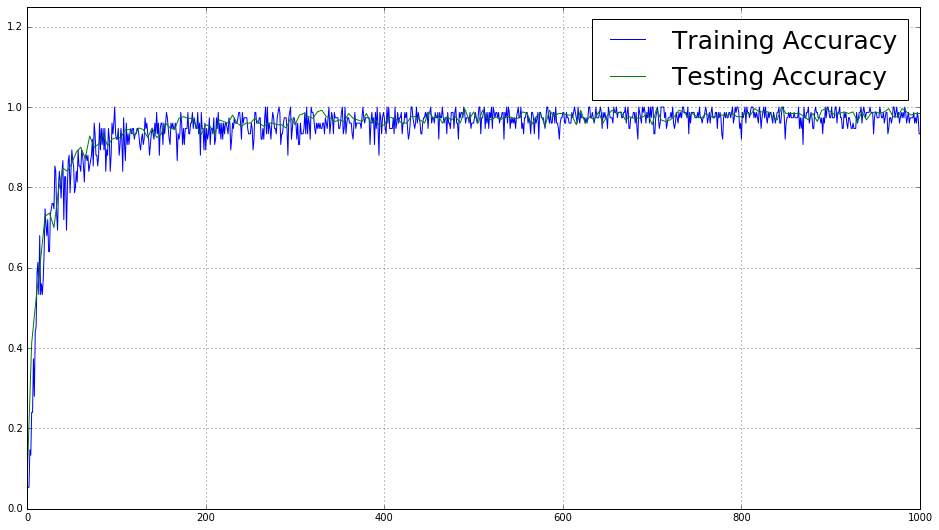

In [96]:
figure = plt.figure(figsize=(16,9))
plt.plot(train_iters, train_accs, label="Training Accuracy")
plt.plot(test_iters, test_accs, label="Testing Accuracy")
plt.grid(True)
plt.legend(fontsize=25)
plt.ylim(0,1.25)
plt.show()

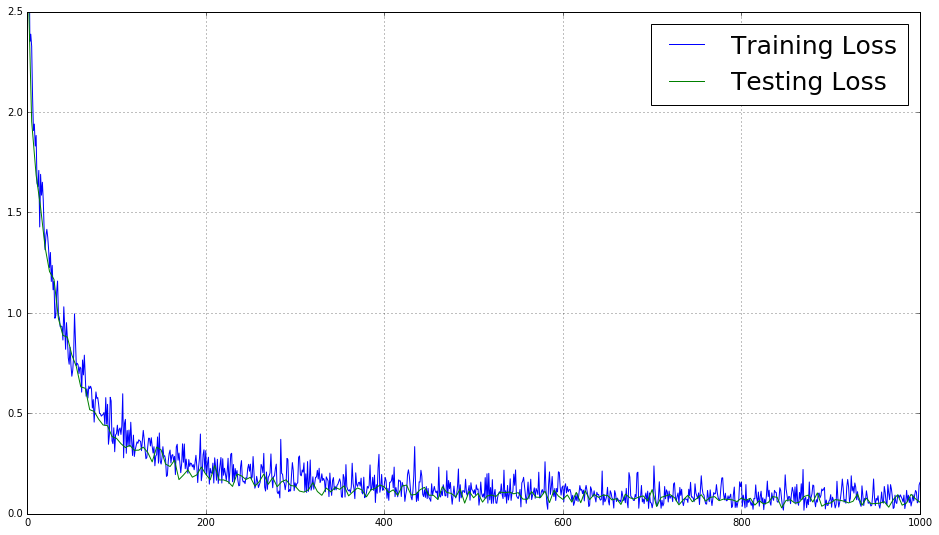

In [97]:
figure = plt.figure(figsize=(16,9))
plt.plot(train_iters, train_losses, label="Training Loss")
plt.plot(test_iters, test_losses, label="Testing Loss")
plt.grid(True)
plt.legend(fontsize=25)
plt.ylim(0,2.5)
plt.show()

Based on this, things look good.  It's not state-of-the-art accuracy but it's pretty good, so let's move on to the second part of the tutorial, restoring the model from file and doing analysis.